In [35]:
import pandas as pd
import intensity_fill

%matplotlib inline

In [36]:
df = pd.read_csv("ravdess_features.csv")

excluded = [
    "modality",
    "vocal_channel",
    # "emotional_intensity",
    "statement",
    "repetition",
    "actor",
    "channels",
    "sample_width",
    "frame_rate",
    "frame_width",
    "sample_width",
    "stft_max",
    "frame_count",
    "length_ms",
    "mean",
    "max","min",
    # "kur","skew",
]
df = intensity_fill.fill_intensity(df)

categorical = ["sex", "emotion", "emotional_intensity"]
df.drop(columns=excluded, inplace=True)
for field in categorical:
    df[field] = pd.Categorical(df[field]).codes

with pd.option_context('display.max_rows', 10, 'display.max_columns', None):  # more options can be specified also
    display(df)

/home/djanloo/Desktop/dynamiting/intensity_fill.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.intensity[df.intensity.isna()] = I_from_std(df["std"][df.intensity.isna()])


,emotion,emotional_intensity,sex,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,stft_skew,std,kur,skew
0,3,0,0,-36.793432,16995,-33.485947,134.654860,-755.22345,171.69092,5792.550744,3328.055457,0.000000,13541.959028,-1.120769,0.250940,0.415250,0.335533,0.000000,-1.215025,0.403514,0.014482,9.406061,0.273153
1,0,0,0,-33.739051,13906,-29.502108,130.485630,-713.98560,205.00770,5197.620555,4040.931570,0.000000,12000.290443,-1.531204,0.219582,0.417488,0.352380,0.000000,-1.384174,0.290905,0.020417,19.564187,0.292157
2,4,1,0,-32.290737,18723,-30.532463,126.577110,-726.06036,165.45653,4830.743037,3332.131300,0.000000,12007.751173,-1.130153,0.436699,0.379758,0.352270,0.000000,-1.242947,0.470350,0.024317,4.881241,0.302659
3,7,0,0,-49.019839,11617,-36.059555,159.725160,-842.94635,190.03609,5376.446478,4053.663073,0.000000,12048.223893,-1.497765,0.098802,0.407277,0.360552,0.000000,-1.445318,0.274756,0.003561,13.040259,-0.081014
4,4,1,0,-31.214503,15137,-31.405996,122.125824,-700.70276,161.13400,5146.012474,3442.724109,0.000000,12025.582707,-1.167544,0.496066,0.415974,0.350655,0.000000,-1.366742,0.318926,0.027522,7.485109,0.414872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,1,1,1,-45.519766,9871,-30.225578,158.845500,-855.92420,208.18497,5886.647366,4114.260257,0.000000,12210.517144,-1.588861,0.184390,0.573838,0.304496,0.000000,-1.075888,-0.310088,0.005260,9.551363,0.759247
2448,1,0,1,-43.342901,8963,-31.160332,157.499700,-825.37410,220.79490,6602.742127,4191.727090,0.000000,12064.561791,-1.614582,-0.113920,0.591010,0.306333,0.000000,-1.026071,-0.408018,0.006836,22.517991,1.073633
2449,6,1,1,-36.197674,9765,-26.135280,138.133210,-768.36536,235.53938,4654.156076,4231.511986,0.000000,12207.179884,-1.337419,0.619346,0.467994,0.347843,0.000000,-1.473789,0.130310,0.015384,4.964319,-0.005821
2450,7,0,1,-45.751265,9716,-28.242815,159.943400,-868.09576,219.84350,5524.736973,3596.031841,760.822547,11981.912464,-1.465594,0.206481,0.578854,0.308684,0.001565,-1.277117,-0.242668,0.005182,13.855588,-0.110966


normalization

In [37]:
from sklearn.preprocessing import MinMaxScaler
X = df.values
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

Manifold knn representation

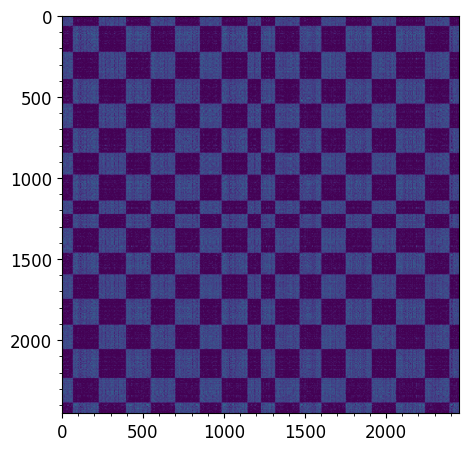

In [38]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
k = 600
A = kneighbors_graph(X_minmax,k, mode='distance', include_self=True)
adj = A.toarray()
plt.imshow(adj)

This result is justified by the fact that the sex feature is divided in groups of males and females. This shows that the male cluster is completely disconnected from the female cluster.

So we first compute the spectral embedding over the complete dataset

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


(-0.0012310110196134467,
 0.0012903376087762873,
 -0.0011884645193045796,
 0.0014260465838947408)

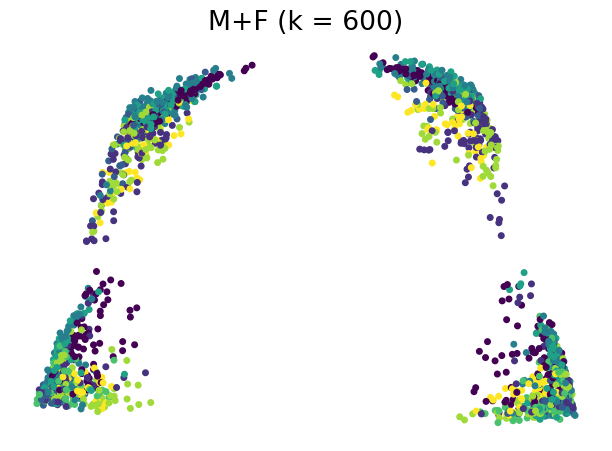

In [39]:
from sklearn.manifold import spectral_embedding
points = spectral_embedding(adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
plt.scatter(points[:,0], points[:,1], c=df.emotion)
plt.title(f"M+F (k = {k})")
plt.axis("off")


Then we divide in males and females

In [75]:
males = df[df.sex==1]
Xmales = MinMaxScaler().fit_transform(males.values)

females = df[df.sex==0]
Xfemales = MinMaxScaler().fit_transform(females.values)

# Reduces the importance of emotional intensity
# in knn distance
alpha = 0.0
Xmales[:,1] *= alpha
Xfemales[:,1] *= alpha

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


(-0.009343449392709698,
 0.011166460943769283,
 -0.009705579101645847,
 0.014173561866387087)

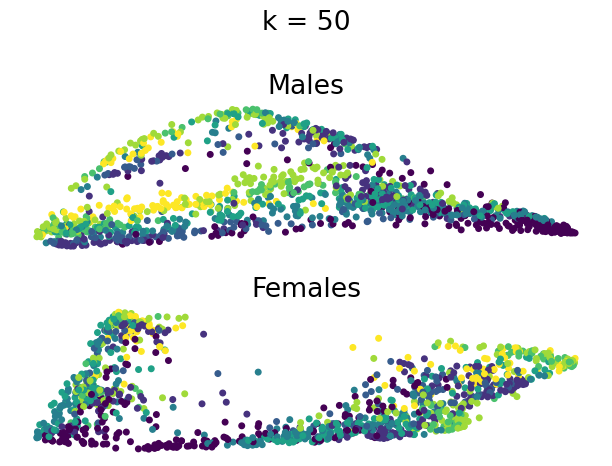

In [77]:
k = 50
males_adj = kneighbors_graph(Xmales, k, mode='distance', include_self=True).toarray()
females_adj = kneighbors_graph(Xfemales, k, mode='distance', include_self=True).toarray()
male_points = spectral_embedding(males_adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
female_points = spectral_embedding(females_adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
fig, axes = plt.subplots(2)
map = axes[0].scatter(male_points[:,0], male_points[:,1], c=df.emotion[df.sex==1])
axes[1].scatter(female_points[:,0], female_points[:,1], c=df.emotion[df.sex==0])
axes[0].axis("off")
fig.suptitle(f"k = {k}")
axes[0].set_title("Males")
axes[1].set_title("Females")
axes[1].axis("off")